In [3]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-sign

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# Gerekli kütüphanelerin import edilmesi
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import random
import pickle
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import requests
from PIL import Image

In [5]:
# Seed değerinin ayarlanması
np.random.seed(0)
tf.random.set_seed(0)

# Veri setinin yüklenmesi
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

# Verilerin ayrılması (özellikler ve etiketler)
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

# Veri boyutlarının kontrolü
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (34799, 32, 32, 3)
X_val shape: (4410, 32, 32, 3)
X_test shape: (12630, 32, 32, 3)


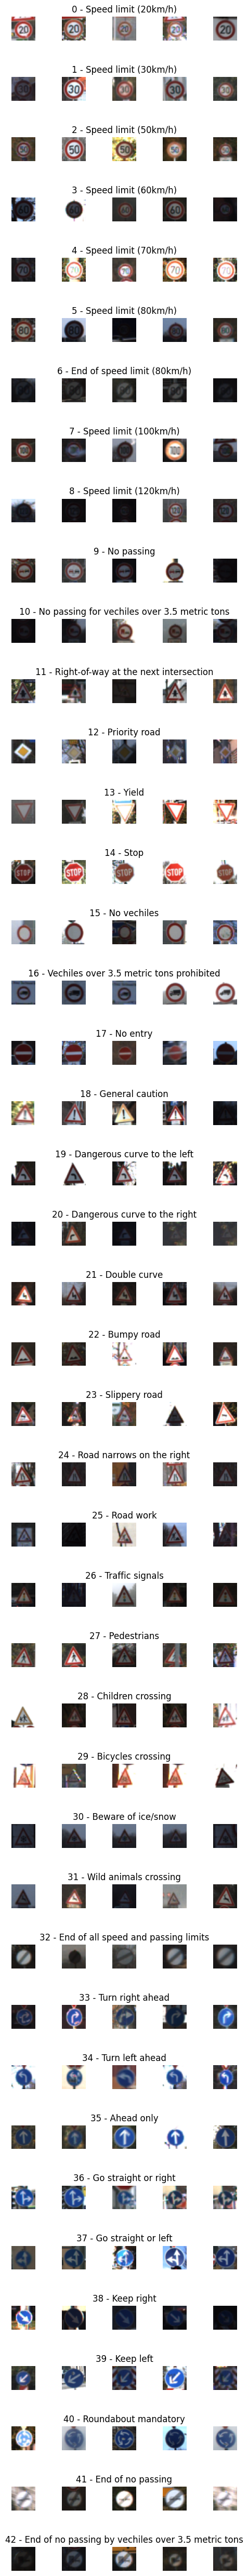

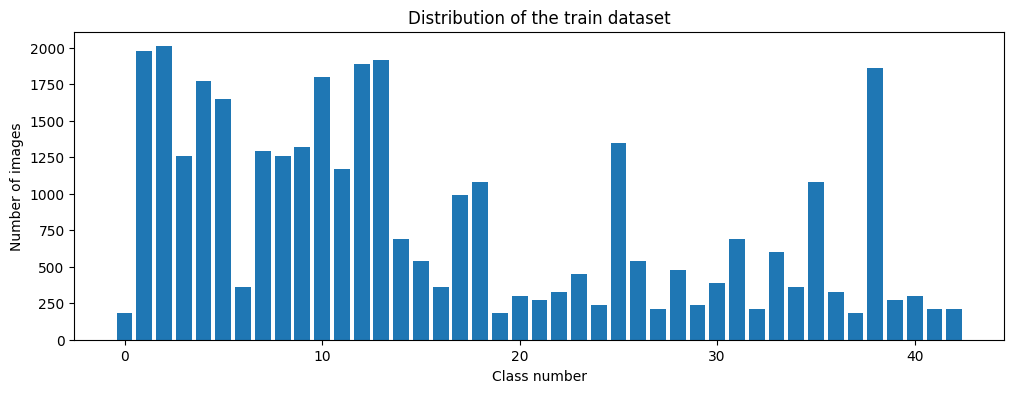

In [9]:
# Veri setinin dağılımının görselleştirilmesi
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        if len(x_selected) > 0:
            axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1))], cmap='gray')
            axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))

# Sınıf dağılımının çubuk grafiği
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


In [10]:
# Görüntü ön işleme fonksiyonları
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

# Verilerin ön işleme adımlarından geçirilmesi
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

# Verilerin yeniden boyutlandırılması
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)

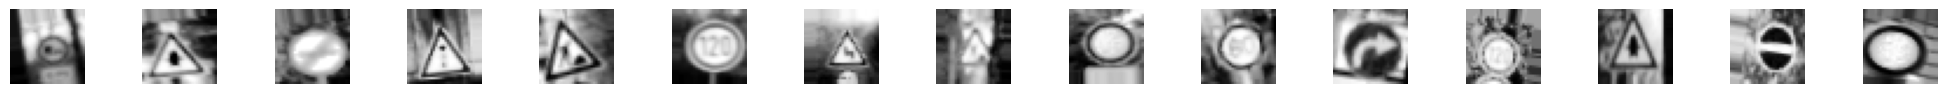

In [11]:
# Veri artırma (Data Augmentation)
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

# Artırılmış verilerin görselleştirilmesi
batches = datagen.flow(X_train, y_train, batch_size=15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32), cmap='gray')
    axs[i].axis("off")

# Etiketlerin kategorik hale getirilmesi
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [12]:
# Modelin oluşturulması
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = modified_model()
print(model.summary())


c:\Users\ENES\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
# Modelin eğitilmesi
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch=2000,
                    epochs=10,
                    validation_data=(X_val, y_val), shuffle=1)

Epoch 1/10


c:\Users\ENES\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
 695/2000 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - accuracy: 0.2817 - loss: 2.6266

c:\Users\ENES\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - accuracy: 0.4223 - loss: 2.0659 - val_accuracy: 0.9073 - val_loss: 0.2966
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.8168 - loss: 0.5899 - val_accuracy: 0.9624 - val_loss: 0.1202
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - accuracy: 0.8904 - loss: 0.3474 - val_accuracy: 0.9828 - val_loss: 0.0657
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.9205 - loss: 0.2533 - val_accuracy: 0.9819 - val_loss: 0.0639
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - accuracy: 0.9330 - loss: 0.2110 - val_accuracy: 0.9766 - val_loss: 0.0693
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.9427 - loss: 0.1826 - val_accuracy: 0.9882 - val_loss: 0.0401
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.9514 - loss: 0.1533 - val_accuracy: 0.9859 - val_loss: 0.0406
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.9548 - loss: 0.14

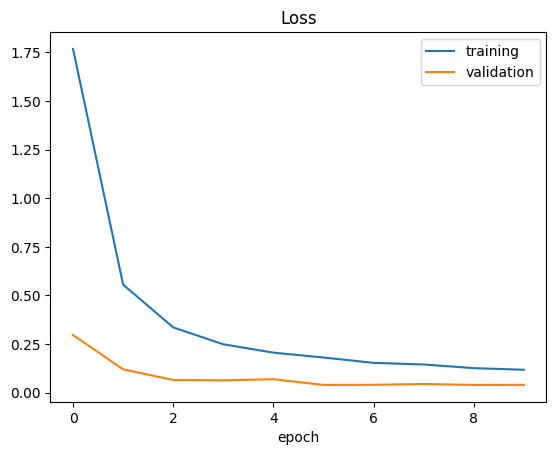

In [14]:
# Eğitim ve validasyon kaybının görselleştirilmesi
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

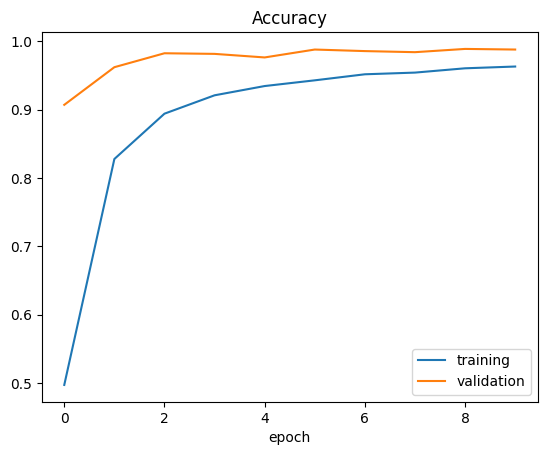

In [15]:
# Eğitim ve validasyon doğruluğunun görselleştirilmesi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()


In [16]:
# Test verisi üzerinde modelin değerlendirilmesi
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])


Test score: 0.11368764936923981
Test accuracy: 0.9710213541984558


(32, 32)


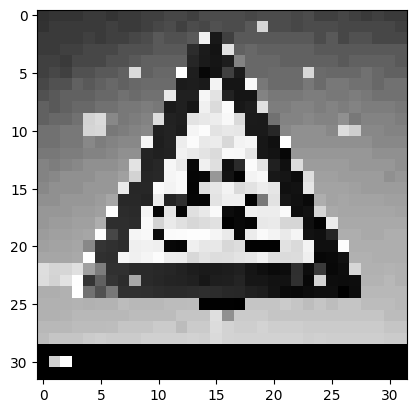

In [19]:
# İnternetten bir görüntü indirilip tahmin yapılması
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)


In [20]:
# Tahmin yapılması
prediction = model.predict(img)
print("Predicted sign: " + str(np.argmax(prediction)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted sign: 29
